https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [1]:
# baseline model with dropout and data augmentation on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers.legacy import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [2]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In [3]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [4]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [5]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [6]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	# prepare iterator
	it_train = datagen.flow(trainX, trainY, batch_size=64)
	# fit model
	steps = int(trainX.shape[0] / 64)
	history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=1, validation_data=(testX, testY))
	# serialize model to JSON
	model_json = model.to_json()
	with open("--model.json", "w") as json_file :
		json_file.write(model_json)
		
	# serialize weights to HDF5
	model.save_weights("--model.h5")
	print("Saved model to disk")
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

In [7]:
# entry point, run the test harness
run_test_harness()

2023-08-01 16:35:01.890529: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-01 16:35:01.890553: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-01 16:35:01.890557: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-01 16:35:01.890585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-01 16:35:01.890601: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/var/folders/bh/fgzl1x4d2551yj9s7tn37qh80000gn/T/ipykernel_3593/467698187.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use 

779/781 [============================>.] - ETA: 0s - loss: 2.1545 - accuracy: 0.2791

2023-08-01 16:35:22.017645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


781/781 [==============================] - 23s 28ms/step - loss: 2.1538 - accuracy: 0.2791 - val_loss: 1.5754 - val_accuracy: 0.4285
Saved model to disk
> 42.850


In [8]:
# evaluate the deep model on the test dataset
from keras.datasets import cifar10
from keras.models import load_model
from keras.utils import to_categorical
from keras.optimizers.legacy import SGD
from tensorflow.keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt

label_names = ['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [10]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	
    # load json and create model
	json_file = open('model.json', 'r')
	loaded_model_json = json_file.read()
	json_file.close()
	loaded_model = model_from_json(loaded_model_json)
	
    # load weights into new model
	loaded_model.load_weights("model.h5")
	print("Loaded model from disk")

	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	loaded_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	# evaluate model on test dataset
	_, acc = loaded_model.evaluate(testX, testY)
	print('> %.3f' % (acc * 100.0))

	y_prob = loaded_model.predict(testX)
	y_classes = y_prob.argmax(axis=-1)
	fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]), figsize=(10,8))
	fig.tight_layout(pad=2)

	print(trainX.shape)
	# print(len(range(0,10)))
	for i, axi in enumerate(ax.flat):		
			color = 'black'
			value = -1
			for n in range(0,10) :
				if testY[i][n] == 1 :
					value = n
			# print(value)
			# print(y_classes[i])
			if y_classes[i]!=value: 
					color='r'	
			axi.imshow(testX[i], cmap='gray_r')
			axi.set_title(label_names[y_classes[i]], color=color)
	plt.axis('off')
	plt.show()	

Loaded model from disk
 12/313 [>.............................] - ETA: 2s - loss: 0.3616 - accuracy: 0.8672

2023-08-01 16:37:31.472839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 9ms/step - loss: 0.3929 - accuracy: 0.8702
> 87.020
 28/313 [=>............................] - ETA: 1s

2023-08-01 16:37:34.619507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step
(50000, 32, 32, 3)


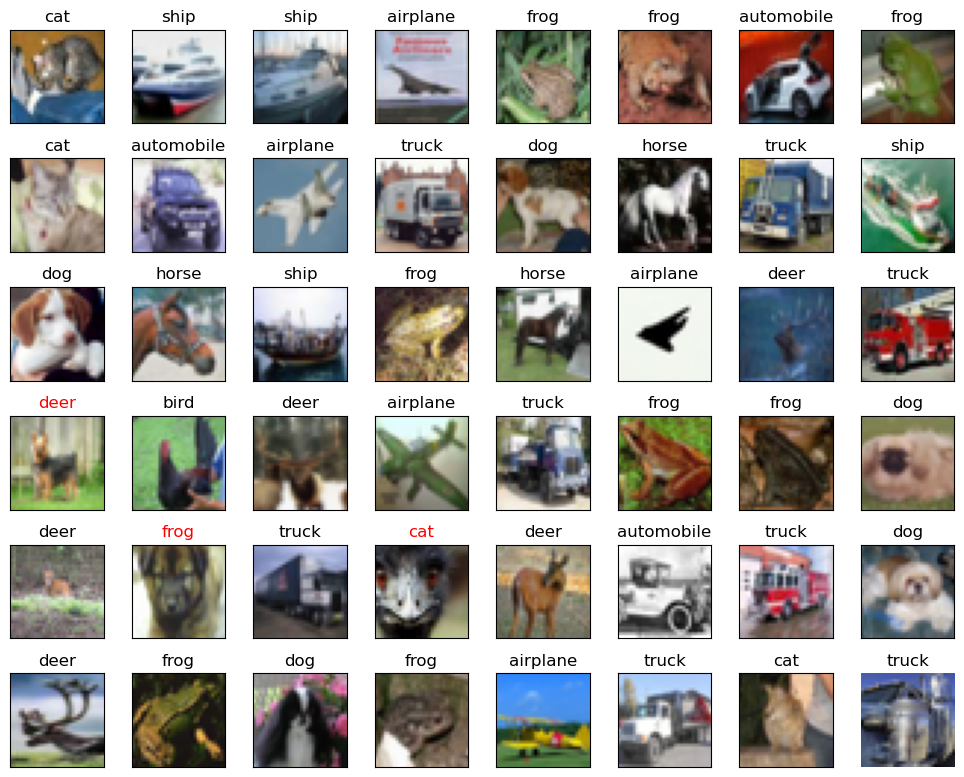

In [11]:
# entry point, run the test harness
run_test_harness()